In [ ]:
library(ggplot2)
library(viridis)
library(dplyr)

plotfactors = function(location,exposures){
        exp1 = exposures/rowSums(exposures)
        exp1 = t(t(exp1)/colSums(exp1)) 
        plotdat = data.frame(x = location[,1], y = location[,2], all = exp1)

        datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1,2)], direction = 'long', v.names = "prob")
        datalong$weight = datalong$prob
        qmax = quantile(datalong$weight, 0.95)
        datalong$weight[datalong$prob > qmax] = qmax


        g1 = ggplot(datalong, aes(x = x, y = y, col = weight))+
        geom_point(cex = 0.2)+ 
        facet_wrap(~time, ncol = 5)+ 
        theme(axis.text = element_blank(),
        axis.ticks=element_blank(), 
        axis.title = element_blank(), legend.position = "none")+
        scale_color_viridis()
        
        return(g1)

}

# Vizgen data

In [5]:
load("modelssaved/cellpose_f20_b150_l200_1e10.RData")
#load("modelssaved/cellpose_f20_nmfgen.RData")

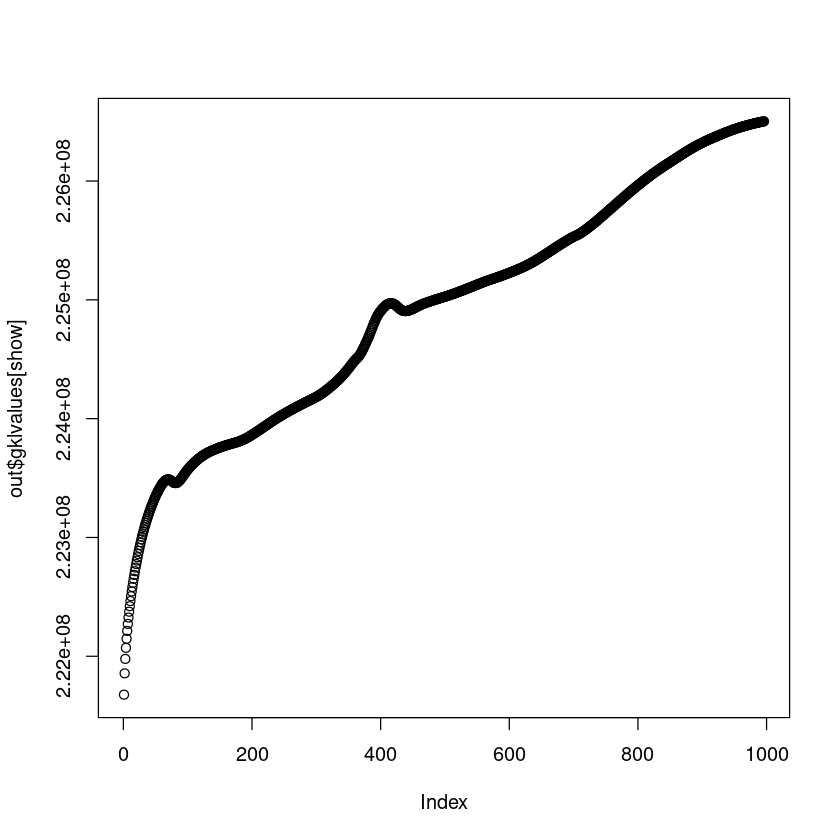

In [7]:
show = c(5:1000)
plot(out$gklvalues[show])

In [6]:
# no gene count 
no_count = read.csv('data/cell_no_gene_count.csv')[,2]

In [7]:
# load data for celltype plot
total = nrow(out$exposures) + length(no_count)
print(total)
celltype = rep("none",total)
cell_annotation = read.csv('data/midlevel_type.csv')

celltype[cell_annotation[,1] + 1] = as.character(cell_annotation[,2])

[1] 844468


In [8]:
celltype = celltype[-no_count]
length(celltype)

[1] 841070

In [9]:
path2 = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_metadata.csv'
metadata = read.csv(path2, row.names = 1)

location = metadata[,c('center_x','center_y')]
location = as.matrix(location)
print(nrow(location))
location = location[-no_count,]

[1] 844468


In [21]:
# get the genes
path1 = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_by_gene_goodgenes_noblanks.csv'
count = read.csv(path1, row.names = 1)
genes = colnames(count)
dim(count)

[1] 844468    492

In [ ]:

# subregion 1
idx_sub = which( location[,1] > 41000 & location[,1] < 48000 &  location[,2] > 17500 & location[,2] < 24500)
#subregion 2
# idx_sub = which( location[,1] > 41000 & location[,1] < 48000 &  location[,2] > 30000 & location[,2] < 37000)
# subregion 3
#idx_sub = which( location[,1] > 36800 & location[,1] < 43800 &  location[,2] > 44000 & location[,2] < 51000)

# random
#idx_sub = sample(length(celltype),50000)


In [ ]:
exp_sub = out$exposures[idx_sub,]
celltype_sub = celltype[idx_sub]

In [ ]:
location_sub = location[idx_sub,]
location_sub[,2] = -location_sub[,2]

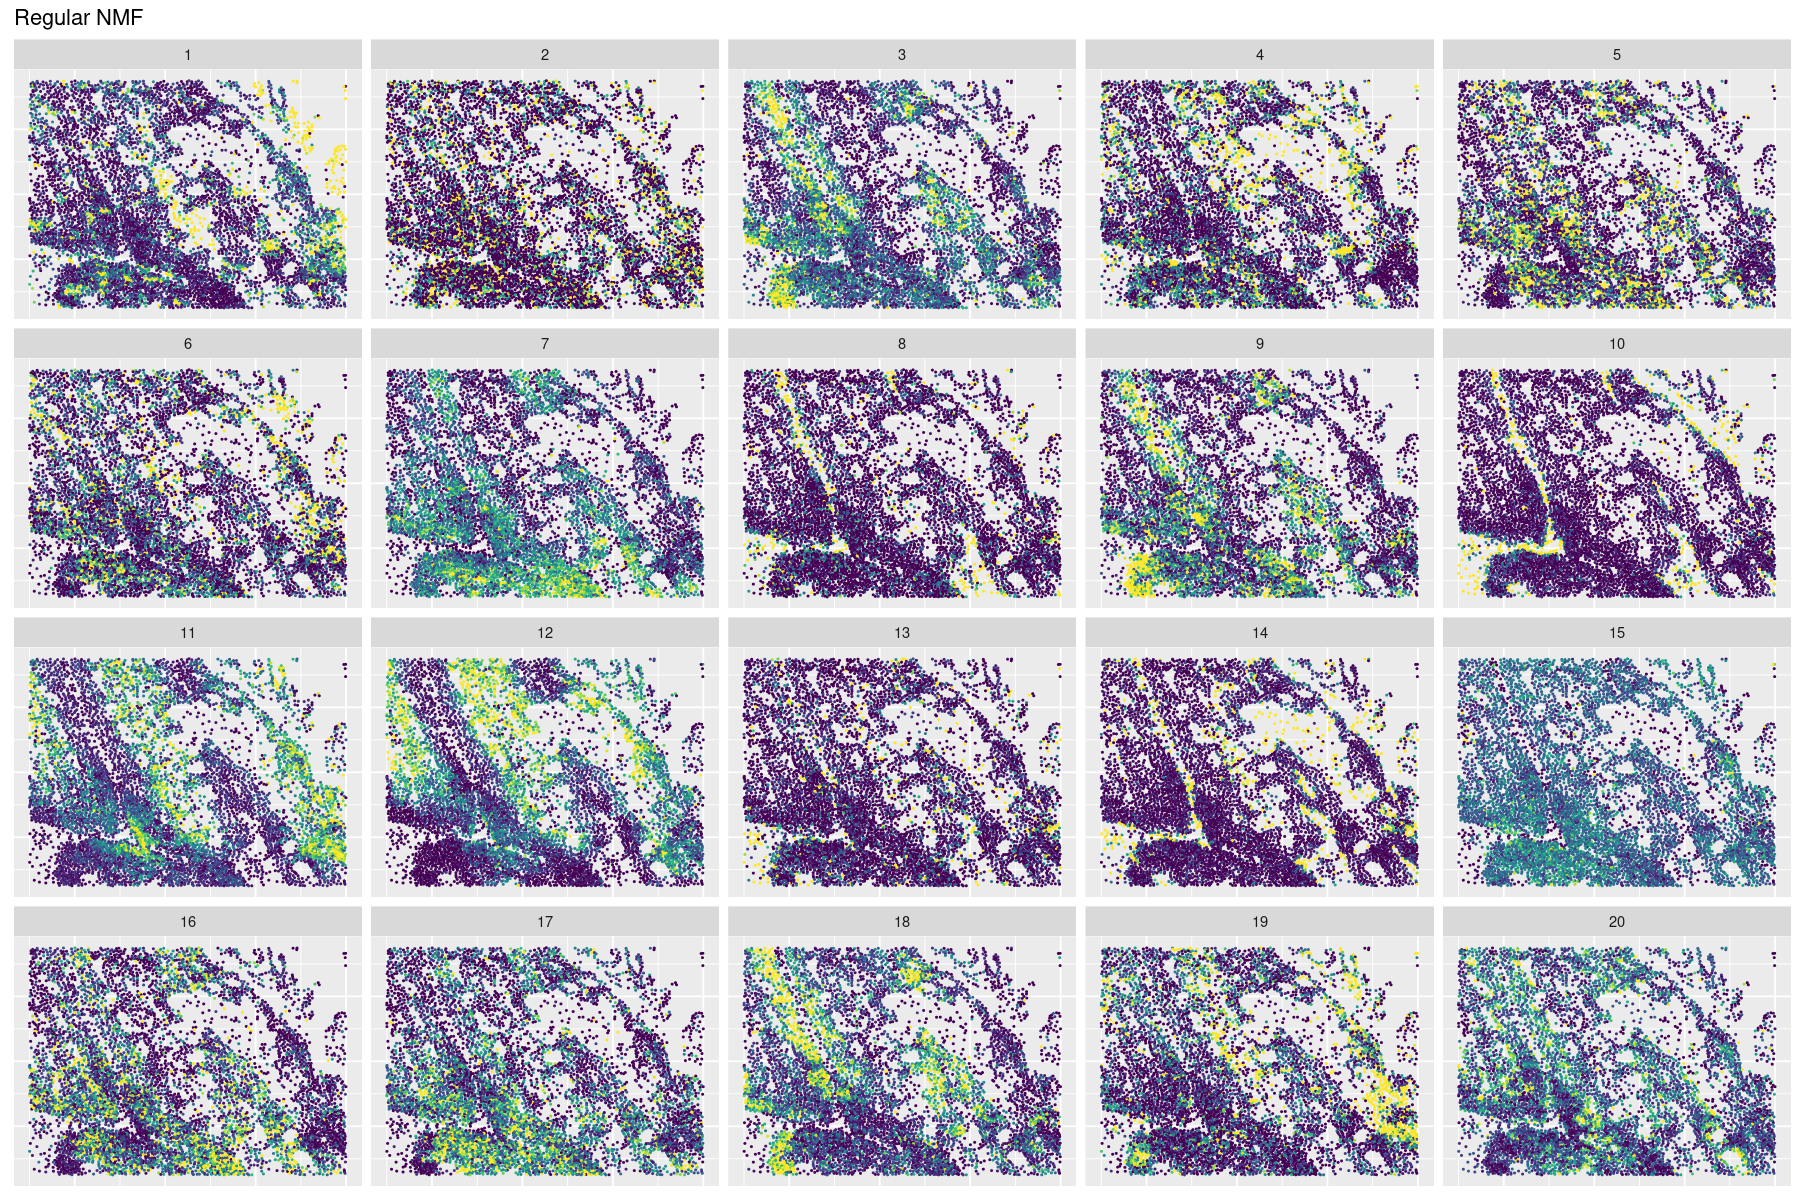

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
plotfactors(location_sub,exp_sub) + ggtitle("Regular NMF")

In [ ]:
orderindex = celltype_sub
norm_exp = exp_sub/rowSums(exp_sub)
for( x in 1:ncol(exp_sub)){
    orderindex = paste0(orderindex,round(norm_exp[,x],2))
}
orderindex = paste0(orderindex, 1:length(orderindex))
plotdat = data.frame(index = orderindex,celltype = celltype_sub, all = norm_exp)

datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1:2)], direction = 'long', v.names = "prob")

datalong$topic = factor(datalong$time)

In [ ]:
myCol = c("pink1", "mediumpurple1", "purple3",
          "turquoise2", "skyblue", "steelblue", "blue2", "navyblue",
          "orange", "tomato", "coral2", "palevioletred", "violetred", "red2",
          "springgreen2", "yellowgreen", "palegreen4", "tan3", "brown",
          "grey70")

length(myCol)

[1] 20

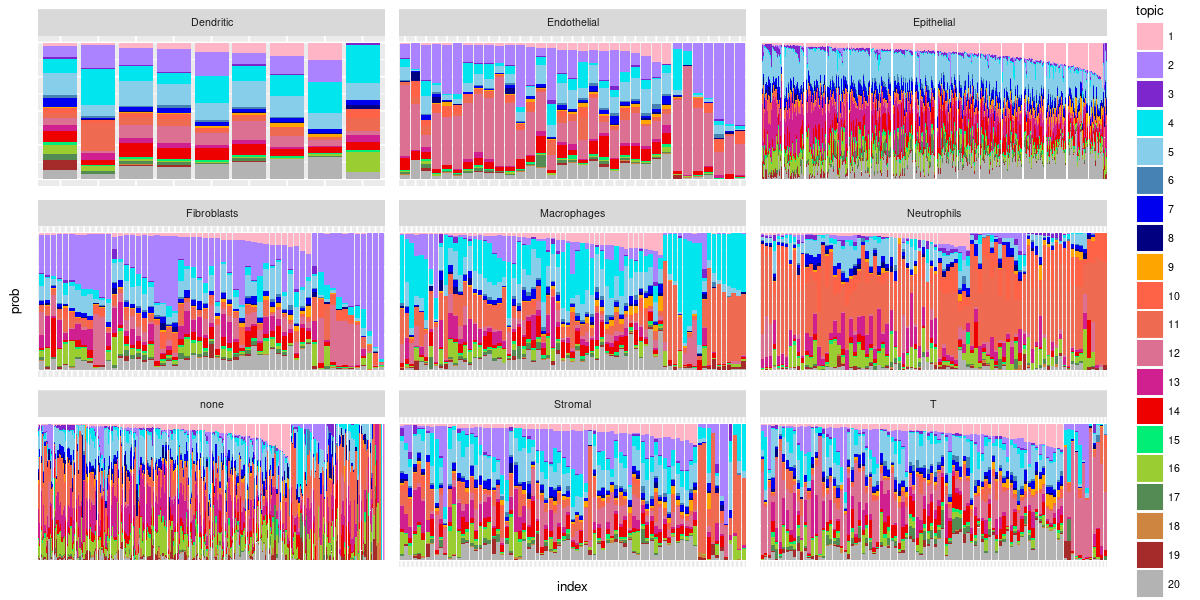

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(datalong, aes(x = index, y = prob, fill = topic))+
         geom_bar(position="stack", stat="identity")+
         theme(axis.text = element_blank(),
         axis.ticks=element_blank(), 
         text = element_text(size = 8))+
         facet_wrap(~celltype, scale = "free")+
         scale_fill_manual(values=myCol)


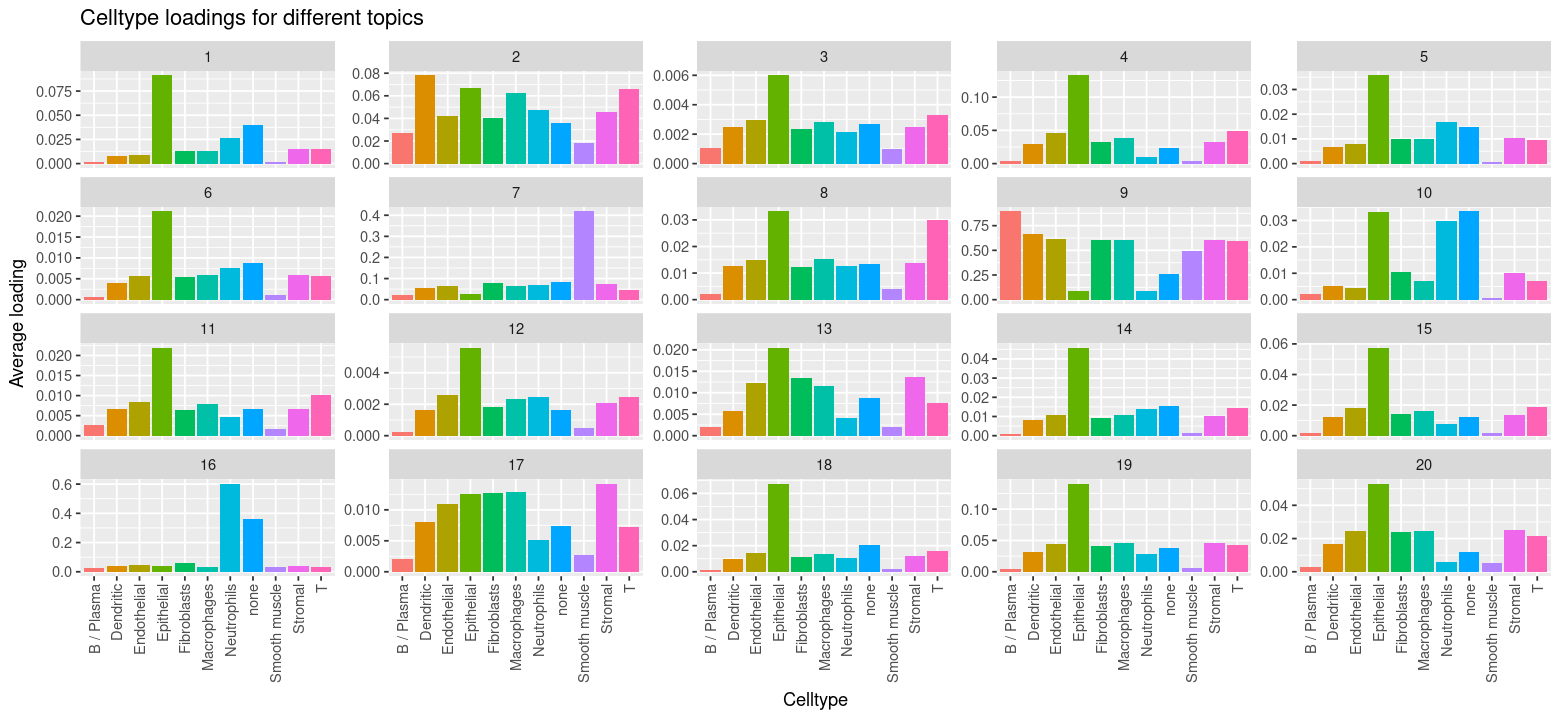

In [ ]:
norm_exp = out$exposures/rowSums(out$exposures)

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), mean)


cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

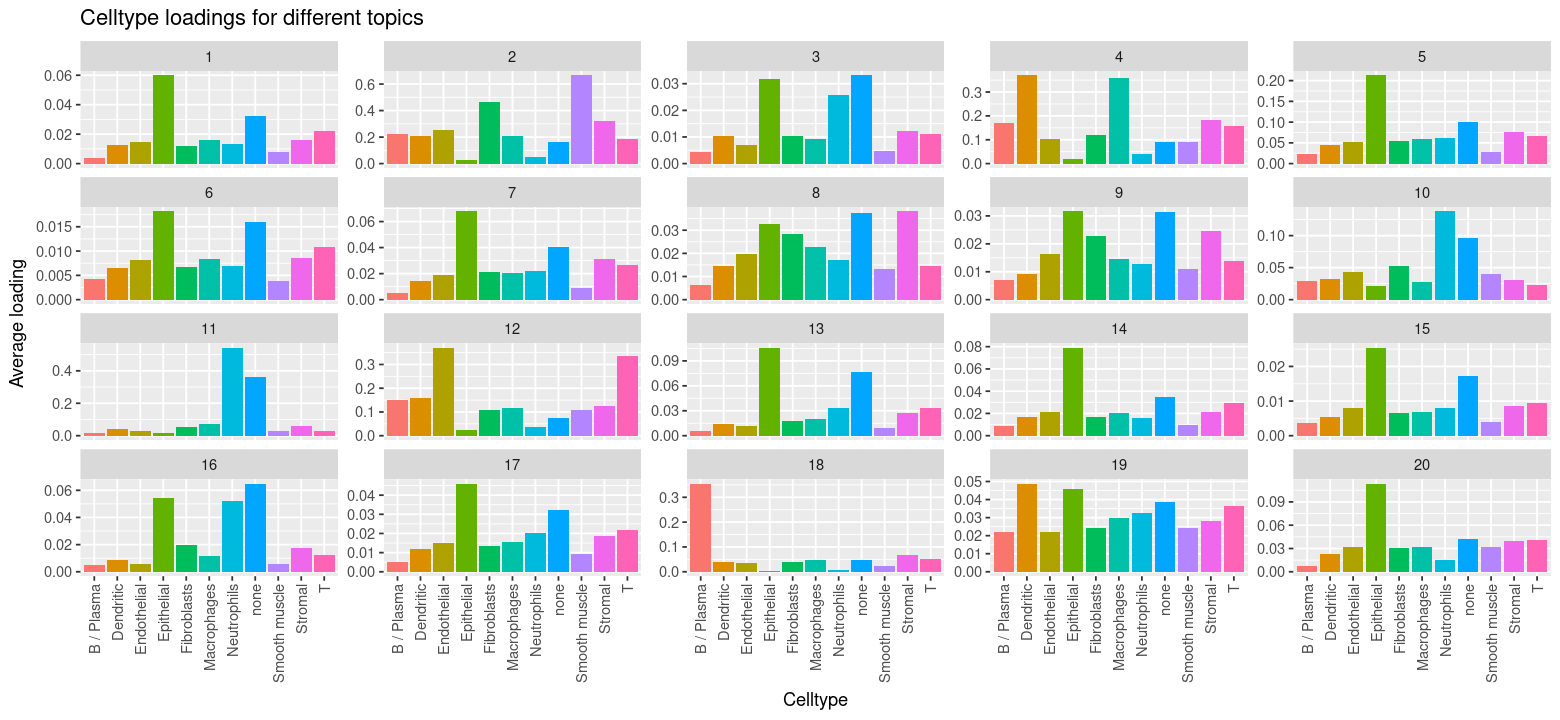

In [34]:


norm_exp = out$exposures/rowSums(out$exposures)

avg_big = function(x){ 
    y = x[x>1e-3]
     
    return(mean(y))
    }

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), avg_big)

#cellmean[,-1] = log(1 + cellmean[,-1]/rowSums(cellmean[,-1]))

cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

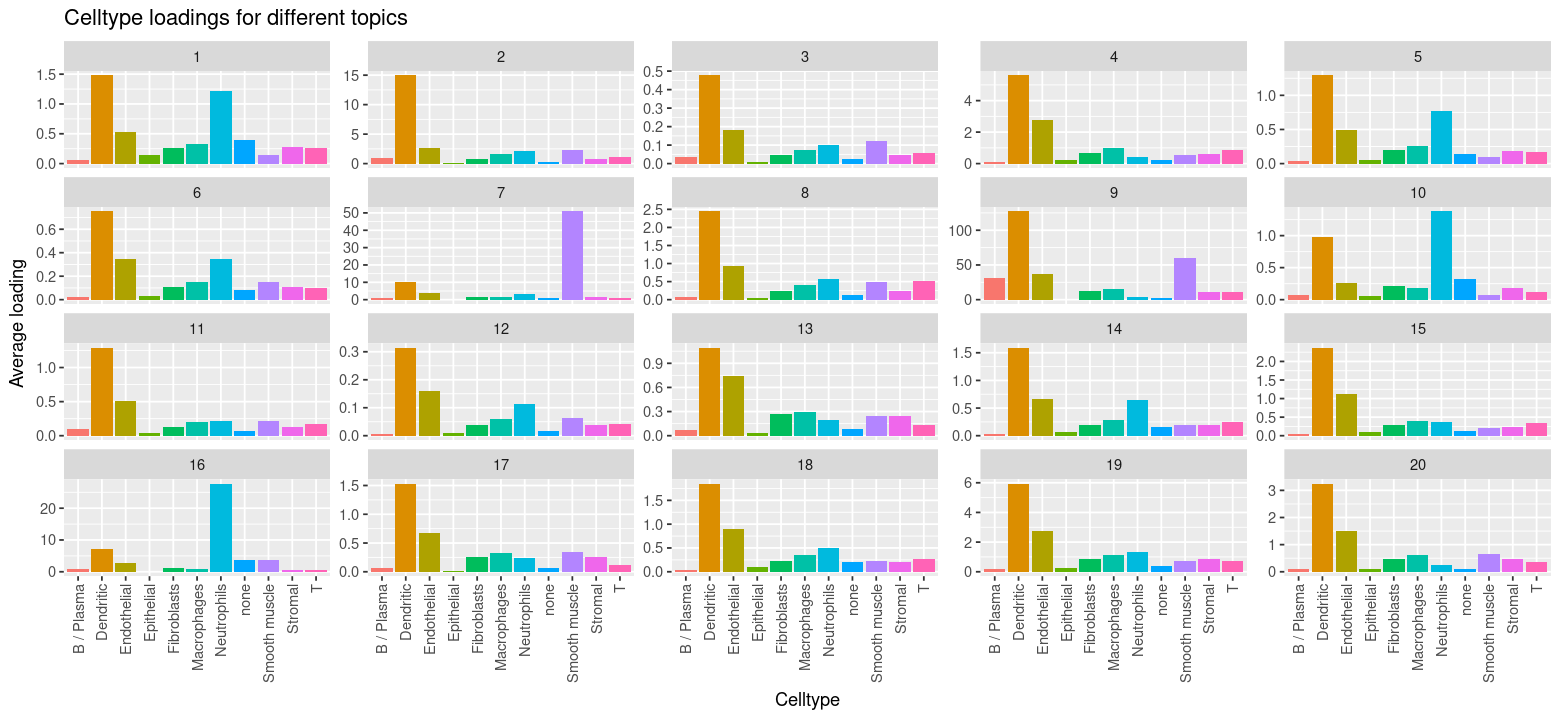

In [25]:
norm_exp = out$exposures/rowSums(out$exposures)

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), function(x) mean(x)/(length(x)/nrow(norm_exp)))

#cellmean[,-1] = log(1 + cellmean[,-1]/rowSums(cellmean[,-1]))

cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

Celltype      norm_exp.1  norm_exp.2 norm_exp.3   norm_exp.4  norm_exp.5  
1  B / Plasma    0.001583734 0.02692631 0.0010281395 0.003448462 0.0009241001
2  Dendritic     0.007714505 0.07802439 0.0024868016 0.029221769 0.0067380966
3  Endothelial   0.008571138 0.04244077 0.0029707443 0.045475162 0.0081082544
4  Epithelial    0.091173638 0.06653748 0.0059901237 0.132664690 0.0356959397
5  Fibroblasts   0.013410305 0.04003225 0.0023717550 0.032070616 0.0099158590
6  Macrophages   0.012949935 0.06273633 0.0028598088 0.038673121 0.0099701033
7  Neutrophils   0.026592440 0.04783649 0.0021543074 0.009682231 0.0168671884
8  none          0.039975293 0.03585902 0.0026827559 0.022852194 0.0149360910
9  Smooth muscle 0.001248197 0.01846906 0.0009885705 0.004475072 0.0008039621
10 Stromal       0.015344384 0.04563002 0.0024655282 0.032301422 0.0104124168
11 T             0.015101519 0.06560164 0.0032893193 0.049042113 0.0096193216
   norm_exp.6  norm_exp.7 norm_exp.8  norm_exp.9 ⋯ norm_exp.11 norm_exp.12 
1  0.000620566 0.02412526 0.002005185 0.89383460 ⋯ 0.002674138 0.0002233517
2  0.003919871 0.05435035 0.012734247 0.66266050 ⋯ 0.006746152 0.0016437346
3  0.005575753 0.06696140 0.014998112 0.61022316 ⋯ 0.008382723 0.0025843706
4  0.021122093 0.02759297 0.033157149 0.09030768 ⋯ 0.021975350 0.0056036352
5  0.005328098 0.07757865 0.012203405 0.60307541 ⋯ 0.006296267 0.0018443490
6  0.005873824 0.06420782 0.015397680 0.60100379 ⋯ 0.007793374 0.0023477602
7  0.007518173 0.06756792 0.012638389 0.09248785 ⋯ 0.004644182 0.0024407953
8  0.008844522 0.08439555 0.013595361 0.25734960 ⋯ 0.006598548 0.0016659757
9  0.001226554 0.41776121 0.003966137 0.49499397 ⋯ 0.001778442 0.0005102413
10 0.005966961 0.07395138 0.013909269 0.60825247 ⋯ 0.006696609 0.0020721554
11 0.005561470 0.04399816 0.029857985 0.59732751 ⋯ 0.010037902 0.0024823523
   norm_exp.13 norm_exp.14 norm_exp.15 norm_exp.16 norm_exp.17 norm_exp.18
1  0.002080258 0.001062644 0.001703938 0.02455233  0.002105402 0.001248038
2  0.005718368 0.008319886 0.012386356 0.03657725  0.007998916 0.009662022
3  0.012188851 0.010891303 0.018406759 0.04293599  0.010963278 0.014552721
4  0.020530350 0.045904381 0.057606395 0.03694998  0.012588741 0.067544585
5  0.013407145 0.009454008 0.013885668 0.05963019  0.012719280 0.010956875
6  0.011573231 0.010975825 0.015991659 0.03318413  0.012888322 0.013957584
7  0.004122053 0.013943103 0.007884618 0.60346302  0.005054118 0.010809492
8  0.008877562 0.015641342 0.012381138 0.36363390  0.007379295 0.020306536
9  0.002027497 0.001523929 0.001699756 0.03173431  0.002784881 0.001804954
10 0.013780881 0.010328614 0.013467097 0.03749822  0.014238201 0.011846183
11 0.007561353 0.014446583 0.018999304 0.03325858  0.007172920 0.015550222
   norm_exp.19 norm_exp.20
1  0.004973148 0.002582454
2  0.031017258 0.016956438
3  0.045075868 0.024408205
4  0.140766645 0.053066460
5  0.041540887 0.023816851
6  0.045726045 0.024769729
7  0.028566487 0.005759493
8  0.037474847 0.012147111
9  0.006045695 0.005501986
10 0.046719391 0.025163030
11 0.042443572 0.021462701

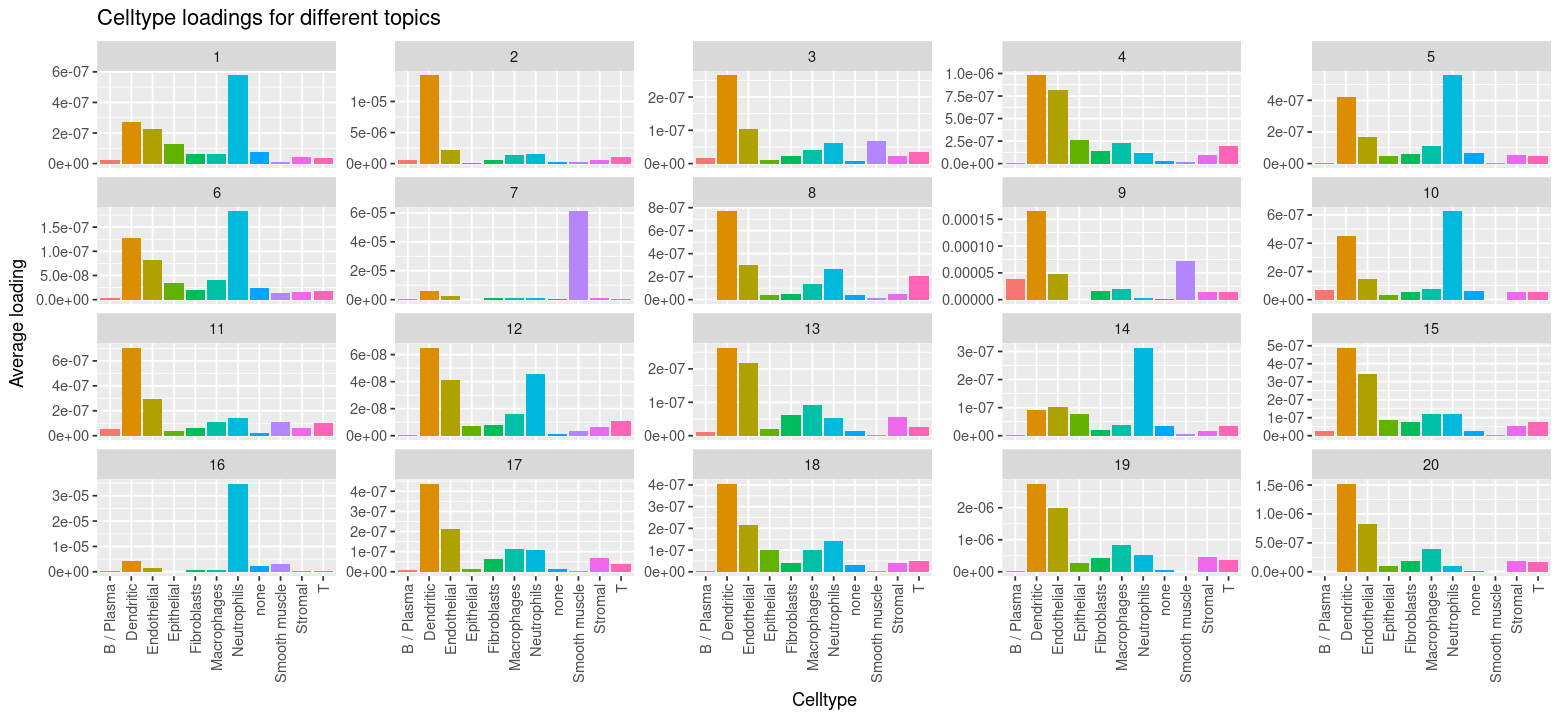

In [ ]:
norm_exp = out$exposures/rowSums(out$exposures)

exp_dat = data.frame(Celltype = celltype, norm_exp = norm_exp)

exp_dat_long = reshape(exp_dat, varying = colnames(exp_dat)[-1], direction = 'long', v.names = "Avg_loading")

avg_mat = exp_dat_long %>% group_by(Celltype) %>% mutate(cell_avg = Avg_loading/sum(Avg_loading))
avg_mat2 = avg_mat %>% group_by(Celltype, time) %>% summarise(fraction = median(cell_avg))


options(repr.plot.width=13, repr.plot.height=6)

ggplot(avg_mat2, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = fraction))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

In [19]:
cell_count = rowSums(count)[-no_count]

In [21]:
idx_20 = cell_count >= 20

In [23]:
data.frame(celltype = celltype[idx_20],cell_count = cell_count[idx_20]) %>% group_by(celltype) %>% summarise(cell_mean = median(cell_count))

celltype      cell_mean
1  B / Plasma    331.0    
2  Dendritic     333.5    
3  Endothelial   424.0    
4  Epithelial    517.0    
5  Fibroblasts   295.0    
6  Macrophages   344.0    
7  Neutrophils    76.0    
8  none           28.0    
9  Smooth muscle 160.0    
10 Stromal        98.0    
11 T             261.0

In [1]:
ggplot(data.frame(celltype,cell_count), aes(x = cell_count))+
geom_histogram()+ 
facet_wrap(~celltype)

ERROR: Error in ggplot(data.frame(celltype, cell_count), aes(x = cell_count)): could not find function "ggplot"


In [ ]:

plotdat = data.frame(x = location[,1], y = location[,2], all = norm_exp[,topic])

In [15]:
# Weighting from paper
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr*log((rr+1e-10)/(mm+1e-10))
  dat_new=rbind(dat_new, ns)
}

weight_topgene = NULL
ng = 50
for(topic in 1:20){
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]

    weight_topgene = rbind(weight_topgene,c(topic,weighting))

}
write.csv(data.frame(weight_topgene), "resultplots/topgenes_cellpose_regnmf.csv", row.names=FALSE)
weight_topgene[,1:26]

[,1] [,2]     [,3]    [,4]    [,5]    [,6]   [,7]   [,8]   [,9]   
 [1,] 1    FOS      EGR1    JUNB    SOCS3   IL1B   PTGS2  CXCL8  ATF3   
 [2,] 2    MZB1     CD79A   XBP1    POU2AF1 FCRL5  IRF4   DERL3  CD27   
 [3,] 3    TGFBI    TGFBR2  IL12B   EGF     SOX2   CASP8  TBX10  DUSP6  
 [4,] 4    CXCL10   HLA.DRA IDO1    TAP2    TAP1   STAT1  HLA.B  CXCL11 
 [5,] 5    MKI67    PLK1    CCNB1   AURKA   BIRC5  FOXM1  AURKB  BUB1   
 [6,] 6    SERPINA1 MMP1    S100A9  CEACAM1 NOS2   MUC1   STAT3  CEACAM8
 [7,] 7    CDH1     EPCAM   ERBB3   SPRY2   TMEM37 SRPRB  SRC    ARAF   
 [8,] 8    PLVAP    VWF     COL4A1  ENG     CDH5   MMRN2  KDR    PGF    
 [9,] 9    EPHB3    PROX1   ASCL2   CTNNB1  CDKN1B NOTCH1 DNMT3A RGMB   
[10,] 10   COL1A1   FN1     ACTA2   COL5A1  PDGFRB SFRP2  DES    MMP11  
[11,] 11   VEGFA    DDIT3   TNFSF9  TCF7L2  CA7    ROS1   ICOSLG WNT3A  
[12,] 12   NDUFA4L2 CA9     SLC26A3 LRP1    LDHA   PKIB   CDKN1A IFNGR2 
[13,] 13   GNLY     GZMA    CD2     CD3E    TRAC   IL2RB  CCL5   CTSW   
[14,] 14   C1QC     LYZ     SPP1    FCGR3A  CSF1R  CYBB   CD14   MMP12  
[15,] 15   SOX9     YAP1    IGF1    IKZF4   PTGDR2 CCL1   VTN    TCL1A  
[16,] 16   MCM2     MCM6    PCNA    E2F1    MSH6   CDK2   MSH2   CDCA7  
[17,] 17   MYC      MUC2    EPHB4   IL12A   IFNGR1 IRS1   CD160  SHARPIN
[18,] 18   AXIN2    PRKCA   LGR6    LRP5    ERBB2  TBX3   IRF3   LEF1   
[19,] 19   LAMC2    LAMB3   EPHA2   BCL2L1  ITGB1  GPX3   AMOTL2 MET    
[20,] 20   PKM      HDAC1   IDH1    NRAS    DIABLO RELA   LMNA   SMAD2  
      [,10]     [,11] [,12]   [,13]   [,14]     [,15]  [,16]    [,17]   
 [1,] JUN       ⋯     CCL3    CXCL5   PROK2     IL6    CXCR1    IL1R2   
 [2,] TNFRSF13C ⋯     BLK     BMI1    MS4A1     HLA.C  STAP1    PIK3CG  
 [3,] CCL1      ⋯     CD68    TCL1A   CCL28     IL22   CCL26    PPARGC1A
 [4,] CIITA     ⋯     TNFSF10 LAMP3   BST2      CCL22  CXCL9    CD274   
 [5,] CHEK2     ⋯     TMEM59  LGR5    IRF5      CXCL2  IL6      LEF1    
 [6,] PRTN3     ⋯     IL4     IDO2    ARG1      IL5RA  PAX5     CLCA1   
 [7,] TBK1      ⋯     TP63    CD1B    FGFBP2    PAX5   PDGFC    CR2     
 [8,] PECAM1    ⋯     ANGPT2  FLT1    ITGA5     THBD   PREX2    IL3RA   
 [9,] LGR5      ⋯     CCL1    VTN     KLRF1     CCL26  PPARGC1A TP63    
[10,] COL11A1   ⋯     FGFR1   TNC     COL6A3    FAP    LOX      SNAI2   
[11,] FABP2     ⋯     CXCR1   STAP1   CTSG      MARCO  SIGLEC1  TNF     
[12,] PLOD2     ⋯     ELANE   CD160   IDO2      IL5RA  CD1B     FGFBP2  
[13,] ZAP70     ⋯     ITK     CD5     STAT4     CCR4   PTPRC    TNFRSF18
[14,] MRC1      ⋯     CD163   ITGAM   TLR2      MAFB   MSR1     CSF2RA  
[15,] CCL28     ⋯     CD1B    RET     TNFRSF13B CD207  MMP2     XCR1    
[16,] MYBL2     ⋯     DNMT1   MLH1    EZH2      NFE2L2 MAP2K1   TEAD4   
[17,] BAK1      ⋯     IDO2    FABP2   PAX5      TBX10  FCER1A   TMEM59  
[18,] STAT6     ⋯     KLRC1   TGFBR3  LRP6      MSH3   IKBKB    CCL11   
[19,] ZBED2     ⋯     TEAD1   DKK1    RET       CD276  IL17A    FOSL1   
[20,] BAX       ⋯     PTGDR2  PGLYRP1 IL13      CD68   TCL1A    XCL1    
      [,18]   [,19]  [,20]  [,21] 
 [1,] CXCR2   CD83   ELANE  CXCL2 
 [2,] IL6R    TMEM59 PAX5   ATM   
 [3,] FLI1    ELANE  CD160  IL4   
 [4,] CSF3    NFKB2  NLRC5  BTLA  
 [5,] RORC    MMP7   CXCL1  TGFBR3
 [6,] CXCR2   ROR1   CCR10  XCR1  
 [7,] CCR3    CXCR2  CD207  FGFR2 
 [8,] KLF2    SNAI1  CAV1   VEGFC 
 [9,] FABP2   IFNB1  CD1B   CCR3  
[10,] ELN     SMO    ITGA1  MFAP5 
[11,] CD22    EPHA4  CXCL5  TGFB2 
[12,] PAX5    RET    PRTN3  CR2   
[13,] GATA3   KLRK1  CD28   IKZF2 
[14,] CD86    ITGB2  CMKLR1 CD209 
[15,] CSF2    ANGPT1 FGF1   HGF   
[16,] WNT3    CD207  HRAS   CR2   
[17,] SELL    ESCO2  FCER2  DKK1  
[18,] SLC13A3 TP63   PIK3CA PMS2  
[19,] KLRF1   TBX10  XCR1   CCL11 
[20,] CCL28   IL22   ELANE  IL10

In [60]:
# More distinct genes
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr/mm
  dat_new=rbind(dat_new, ns)
}

weight_topgene = NULL
ng = 50
for(topic in 1:20){
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]

    weight_topgene = rbind(weight_topgene,c(topic,weighting))

}

weight_topgene

write.csv(data.frame(weight_topgene), "resultplots/topgenes_cellpose_l500_distinct.csv", row.names=FALSE)


[,1] [,2]     [,3]   [,4]    [,5]     [,6]   [,7]   [,8]    [,9]    
 [1,] 1    NDUFA4L2 PLOD2  LRP1    LDHA     CA9    PDK1   IFNGR2  CD70    
 [2,] 2    CXCL10   IDO1   CXCL11  CIITA    CX3CL1 CXCL9  HLA.DRA FGFBP2  
 [3,] 3    PLK1     CCNB1  BUB1    AURKA    BIRC5  MKI67  AURKB   FOXM1   
 [4,] 4    CDCA7    SRPRB  ATR     BMI1     RAF1   SPRY2  RGMB    RB1     
 [5,] 5    SERPINA1 S100A9 CEACAM8 TAPBP    STAT3  IFNGR1 DUSP6   CEACAM1 
 [6,] 6    SOX9     MYC    WNT3    IKBKB    TCF7L2 LGR6   SHARPIN BRD4    
 [7,] 7    DES      SPP1   MYH11   MMP12    TNC    MMP9   MARCO   SERPINE1
 [8,] 8    GNLY     GZMA   CTSW    TNFRSF18 SH2D1B NKG7   IL2RB   NCR3    
 [9,] 9    COL1A1   SFRP2  C1QC    PECAM1   MZB1   PLVAP  ENG     POU2AF1 
[10,] 10   DDIT3    TNFSF9 PPARD   RELA     VEGFA  CA7    ROS1    LAMP3   
[11,] 11   MYBL2    BRCA1  CDK2    EZH2     E2F1   PCNA   CCNE1   ESCO2   
[12,] 12   MUC2     NOS3   CD1B    TEAD1    NLRC5  IL12A  ELANE   BAK1    
[13,] 13   GPX3     PROX1  LGR5    FGFR2    TGFB1  EPHB3  IGF1R   TCF7L2  
[14,] 14   SELP     TGFB2  HLA.B   FCER2    HLA.C  IFNB1  MPO     CXCL16  
[15,] 15   LEF1     PRKCA  CCR6    NOTCH1   AXIN2  DNMT3A TP63    TSC1    
[16,] 16   FOS      IL1B   PTGS2   FFAR2    EGR1   CSF3R  SOCS3   CXCR1   
[17,] 17   LAMC2    ZBED2  MMP7    FGF2     PDGFB  LAMB3  CCND1   EPHA2   
[18,] 18   SLC26A3  FABP2  NRAS    RORC     NEDD4  NFE2L2 FGFR3   FZD7    
[19,] 19   PKM      HRAS   LMNA    AKT1     MAP2K1 CCR3   PDGFC   HDAC1   
[20,] 20   TGFBI    TGFBR2 CTNNB1  EGF      JUN    CASP8  LGR6    PIK3CA  
      [,10]   [,11] [,12]     [,13]  [,14]   [,15]  [,16]   [,17]  [,18]  
 [1,] ROS1    ⋯     PIK3CA    IKZF4  TMEM59  JUN    CCL1    KLRF1  TNFSF10
 [2,] STAT1   ⋯     TNFRSF9   SOD2   CCL8    NFKB1  CCL28   MTOR   CR2    
 [3,] IL13    ⋯     TNFRSF13B XCR1   ANGPT1  IL4    TEK     FGF1   FGFBP2 
 [4,] SMARCA4 ⋯     CREBBP    MTOR   AKT2    IKBKB  IDH1    HDAC1  PIK3CA 
 [5,] TNFRSF9 ⋯     IFNAR2    IFNG   CXCL16  CDH1   TCL1A   MMP2   PRF1   
 [6,] SMARCA4 ⋯     PRKCA     IL12A  PMS2    PDGFA  MET     EPHA2  NEDD4  
 [7,] ITGA5   ⋯     STAT6     NCAM1  MMRN1   CXCL5  SHARPIN CREBBP VEGFB  
 [8,] CD244   ⋯     TSC2      IFNGR1 CCL28   CD3E   MAML1   CD226  DIABLO 
 [9,] CD79A   ⋯     FOXP3     ICOS   CD86    CDH5   FAP     CD28   PDGFRA 
[10,] IL5RA   ⋯     CCR3      PMS2   AKT2    LAMB3  PLOD2   FOSL1  CD68   
[11,] MCM2    ⋯     CCNB1     CCR7   WNT3    HDAC1  RB1     MYH11  ADAMTS4
[12,] NFKB2   ⋯     KLRF1     PTGDR2 CCL26   IL17A  VTN     IDO2   KIR3DL2
[13,] IRF3    ⋯     STAT6     FGFR3  TGFBR3  TSC1   CDH1    LGALS9 PMS2   
[14,] STAP1   ⋯     CDH1      CREBBP CXCR3   IGF1   IGF1R   XCL1   HDAC1  
[15,] CCL11   ⋯     LRP5      STAT6  BRD4    PAX5   APC     MSH3   GZMB   
[16,] PROK2   ⋯     TEK       CLCA1  IDO2    CR2    ATF3    IL5RA  FLT1   
[17,] DKK1    ⋯     CD160     IDO2   KIR3DL2 XCL1   TGM2    CD1E   TSC2   
[18,] CDKN1A  ⋯     SIGLEC1   RB1    SMAD2   TGFBR1 IKBKB   IFNAR2 PREX2  
[19,] MTOR    ⋯     CR2       NFKB1  TBK1    CD177  MET     CTNNB1 XCL1   
[20,] IL12B   ⋯     SOX2      IKZF4  IL23A   CREBBP PDGFA   BRAF   TEAD1  
      [,19]   [,20]     [,21]  
 [1,] IFNGR1  PKM       TGFBR1 
 [2,] CSF3    CXCR5     TBX21  
 [3,] CLDN5   ROS1      CCL8   
 [4,] HDAC3   ARAF      TGFBR1 
 [5,] IKBKB   MFAP5     TBK1   
 [6,] EPHB4   IFNGR1    HLA.DMA
 [7,] IKBKB   ELN       APC    
 [8,] KLRC1   PTK2      STAT6  
 [9,] CD40    IL2RA     ZEB1   
[10,] IL23A   SNAI1     IL17A  
[11,] CX3CR1  PDK1      IL13   
[12,] XCL1    TGM2      CD1E   
[13,] AXIN2   IL23A     NOTCH1 
[14,] SIGLEC1 TNFRSF13B VEGFB  
[15,] IRF3    SRC       CDKN1B 
[16,] TCL1A   KIR3DL2   FCGR2A 
[17,] CCL1    CCL28     CXCR5  
[18,] MAFB    PIK3CA    MAP2K1 
[19,] RELA    KLRF1     BAK1   
[20,] KIR2DL4 TAP2      DNMT3A

In [53]:
library(pals)

ERROR: Error in library(pals): there is no package called ‘pals’


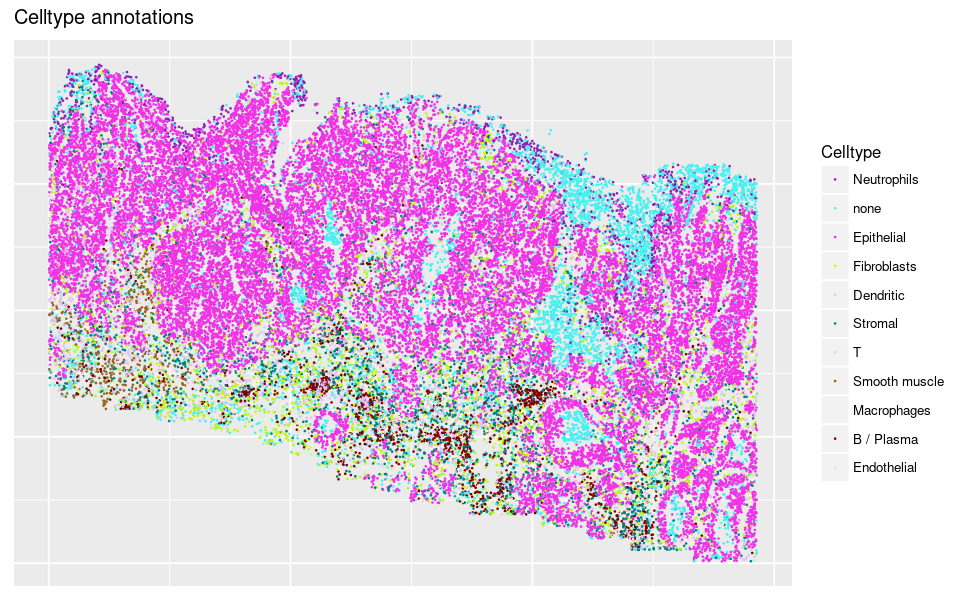

In [17]:
myCol = c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000')

options(repr.plot.width=8, repr.plot.height=5)
dat1 = data.frame(x = location_sub[,1], y = location_sub[,2], Celltype = celltype_sub)
dat1$Celltype = factor(dat1$Celltype, levels = unique(dat1$Celltype))
ggplot(dat1, aes(x = x, y = y, color = Celltype))+
        geom_point(cex = 0.1, alpha = 1)+
        #facet_wrap(~type)+
        theme(text = element_text(size = 10), 
        axis.text = element_blank(),
        axis.ticks=element_blank(), 
        axis.title = element_blank()
        )+
        ggtitle("Celltype annotations")+
        scale_color_manual(values=myCol[6:16])
        

In [55]:
sum(celltype == 'Epithelial cells')

[1] 516739